In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [2]:
import stan_utility

In [3]:
import stan

# Bayesian Inference

### fake data

In [4]:
from faker import Faker # library for generating random num

In [5]:
faker = Faker()
Faker.seed(1000)

In [6]:
# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(3000)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(3000)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'Insulin': [faker.random_int() for _ in range(3000)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(3000)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(3000)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(3000)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(3000)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

Pregnancies  Glucose  BloodPressure  SkinTickness  Insulin        BMI  \
0           13       59             24            99     6861  40.375093   
1            3      198             62            54     7416  60.019936   
2           12       89             42            80     7606  29.901838   
3           11      169             66            73     9796  18.782294   
4            2       24             60            76      247  13.799934   

   DiabetesPedigreeFunction  Age  Outcome  
0                  1.122980   90        1  
1                  1.164683   84        1  
2                  0.776493   50        0  
3                  2.959806   82        1  
4                  1.003071   90        0

In [7]:
df_simu.describe()

Pregnancies      Glucose  BloodPressure  SkinTickness      Insulin  \
count  3000.000000  3000.000000    3000.000000   3000.000000  3000.000000   
mean      8.546000   101.152667      50.608333     49.796667  4960.285333   
std       5.159078    58.629718      29.006288     29.239134  2856.292654   
min       0.000000     0.000000       0.000000      0.000000     2.000000   
25%       4.000000    51.000000      26.000000     25.000000  2485.250000   
50%       8.000000   102.000000      51.000000     50.000000  4942.500000   
75%      13.000000   153.000000      75.000000     75.000000  7436.250000   
max      17.000000   200.000000     100.000000    100.000000  9994.000000   

               BMI  DiabetesPedigreeFunction          Age      Outcome  
count  3000.000000               3000.000000  3000.000000  3000.000000  
mean     33.350612                  1.487909    50.666667     0.497333  
std      19.085782                  0.867345    29.201538     0.500076  
min       0.013702                  0.000393     1.000000     0.000000  
25%      16.784712                  0.733832    25.000000     0.000000  
50%      33.096036                  1.477582    50.000000     0.000000  
75%      49.275035                  2.233451    77.000000     1.000000  
max      66.993839                  2.999799   100.000000     1.000000

/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_41102/2277086940.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')


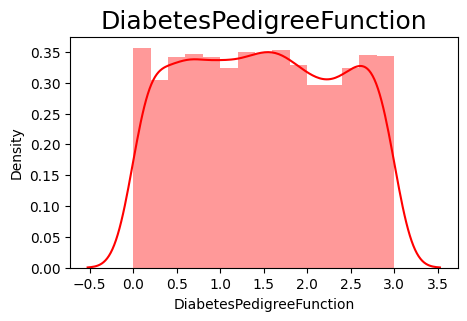

In [8]:
plt.figure(figsize=(5,3))
sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')
plt.title('DiabetesPedigreeFunction',size=18)
# plt.xlabel('Charges',size=14)
# plt.ylabel('Density',size=14)
plt.show()

<Axes: xlabel='Glucose', ylabel='DiabetesPedigreeFunction'>

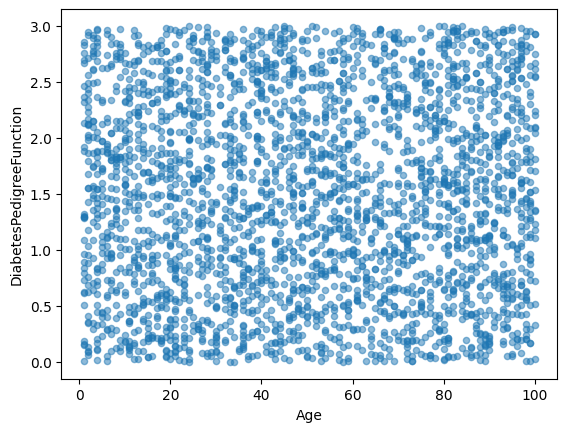

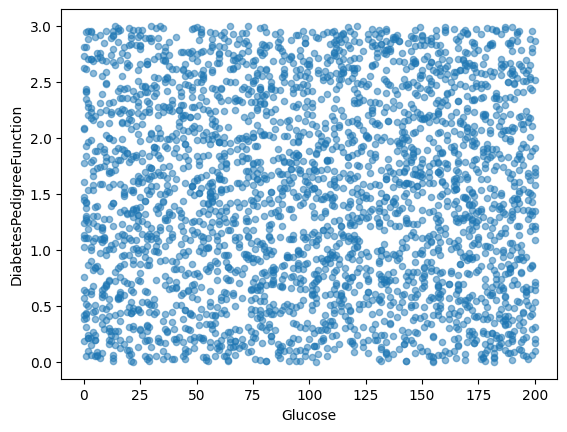

In [9]:
# print(df.loc[:, 'Outcome'].values)
df_simu.sort_values(by='Age').reset_index(drop=True).plot.scatter(x='Age', y="DiabetesPedigreeFunction", alpha=0.5)
df_simu.sort_values(by='Glucose').reset_index(drop=True).plot.scatter(x='Glucose', y="DiabetesPedigreeFunction", alpha=0.5)

## 1. Bayseian modeling

In [10]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [11]:
import pandas as pd
import csv

In [12]:
import scipy.stats as stats

In [13]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [35]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [36]:
# df["age_over35"] = (df['Age'] > 35).astype(int)

In [37]:
df.head(10)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96              0        0   0.0   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
5                     0.201   30        0  
6                     0.248   26        1  
7                     0.134   29        0  
8                     0.158   53        1  
9                     0.232   54        1

In [38]:
df.corr()

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221071                  0.137337   
BloodPressure             0.088933  0.281805                  0.041265   
SkinThickness             0.436783  0.392573                  0.183928   
Insulin                   1.000000  0.197859                  0.185071   
BMI                       0.197859  1.000000                  0.140647   
DiabetesPedigreeFunction  0.185071  0.140647                  1.000000   
Age                      -0.042163  0.036242                  0.033561   
Outcome                   0.130548  0.292695                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.263514  0.466581  
BloodPressure             0.239528  0.065068  
SkinThickness            -0.113970  0.074752  
Insulin                  -0.042163  0.130548  
BMI                       0.036242  0.292695  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

<Axes: >

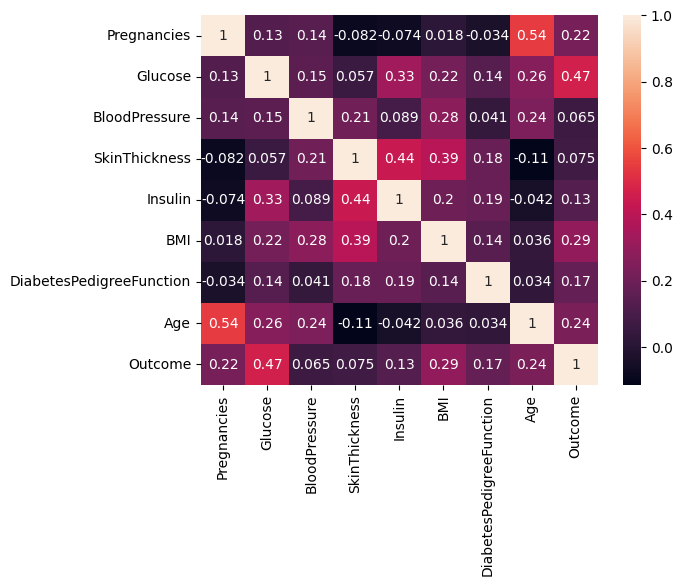

In [39]:
sns.heatmap(df.corr(),annot=True)


<Axes: ylabel='Count'>

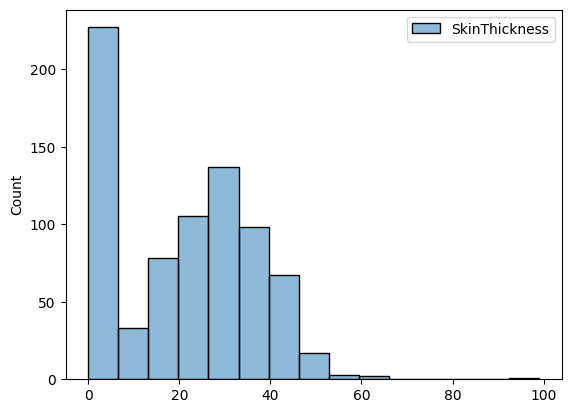

In [40]:
sns.histplot(data=[df['SkinThickness']])

##age, DiabetesPedigreeFunction

<Axes: ylabel='Count'>

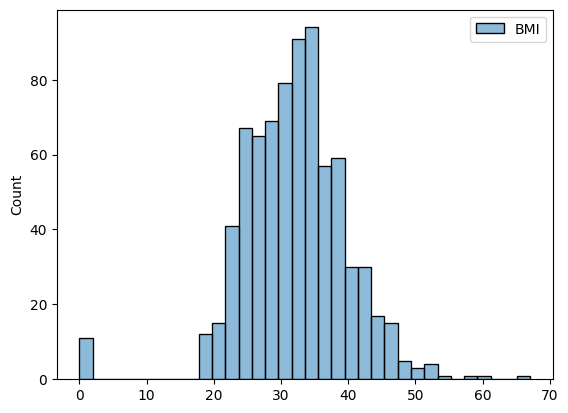

In [41]:
sns.histplot(data=[df['BMI']])


<Axes: ylabel='Count'>

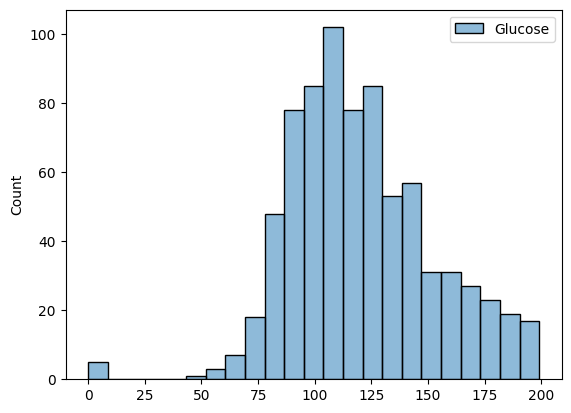

In [42]:
sns.histplot(data=[df['Glucose']])
#age, glucos, BMI

#### Explain the model
1. Data variables
2. Likelihood function and parameters
3. Prior distribution
4. Formal specification
5. Prior predictive check

## 2. Details of the computation



In [43]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] glucose;
     vector[N] diabetes;
     vector[N] bmi;
}

parameters {
    //prob of success
    real alpha;
    real beta;
    real beta2;
    real<lower=0> sigma;
}

model {
    //prior
    alpha ~ normal(0, 5);
    beta ~ normal(0, 5);
    beta2 ~ normal(0,5);
    sigma ~ cauchy(0, 10);
    diabetes ~ gamma(alpha + beta * glucose + beta2 * bmi, sigma); //likelihood
}

generated quantities {
    vector[N] log_lik;
    vector[N] diabetes_pred;

    //log-likelihood
    for (n in 1:N){
     log_lik[n] = gamma_lpdf(diabetes[n] | alpha + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
    
    //predictive 
     for (n in 1:N) {
        diabetes_pred[n] = gamma_rng(alpha + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
}

"""


### 2-1. Specify data

In [44]:
data = {
"N": len(df), 
"glucose": df.loc[:, "Glucose"].values,
"diabetes": df.loc[:, "DiabetesPedigreeFunction"].values,
"bmi": df.loc[:, "BMI"].values,

}

### 2-2. Build model

In [45]:
stan_model = stan.build(stan_code, data=data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.9s
Building: 5.0s
Building: 5.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.3s
Building: 7.4s
Building: 7.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.6s
Building: 7.7s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:320:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:365:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file i

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/h2b2yeyb/model_h2b2yeyb.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warn

### 2-3 Fit the model

- quantify with Hamiltonian Monte Carlo


In [46]:
fit = stan_model.fixed_param(num_chains=2, num_samples=300) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:  50% (300/600)
Sampling: 100% (600/600)
Sampling: 100% (600/600), done.
Messages received during sampling:
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Shape parameter[1] is -61.5261, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_0l5_08ya/model_h2b2yeyb.stan', line 25, column 4 to column 66)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Shape parameter[76] is -5.6194, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_0l5_08ya/model_h2b2yeyb.stan', line 25, column 4 to column 66)
  Rejecting initial value:
    Error evaluating the log probability at the initial value.
  Exception: gamma_lpdf: Shape parameter[1] is -13.6599, but must be positive finite! (in '/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/httpstan_0l5_08ya/model_h2b2yeyb.s

In [48]:
stan_data_simu = az.from_pystan(
    posterior=fit,
    posterior_predictive="diabetes_pred",
    log_likelihood={
        "diabetes": "log_lik",
    },
    observed_data=["diabetes"],
    posterior_model=stan_model,
    coords={"diabetes": np.arange(data["N"])},
)

In [49]:
stan_data_simu

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: xlabel='diabetes / diabetes_pred'>

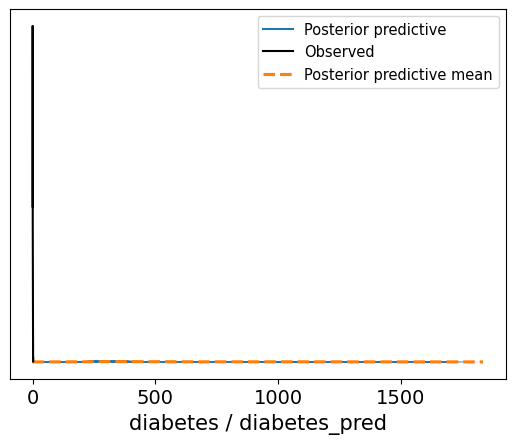

In [50]:
az.plot_ppc(stan_data_simu, data_pairs={"diabetes": "diabetes_pred"}, alpha=0.03, textsize=14)

In [51]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/eunkang/opt/anacond

In [52]:
summary1

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
alpha                -0.785    0.568   -1.352    -0.218      0.396    0.334   
beta                  1.652    0.046    1.607     1.698      0.032    0.027   
beta2                 0.313    0.096    0.217     0.409      0.067    0.056   
sigma                 0.434    0.217    0.217     0.650      0.151    0.127   
diabetes_pred[0]    776.316  384.749  348.378  1240.931    266.192  223.419   
...                     ...      ...      ...       ...        ...      ...   
diabetes_pred[763]  538.170  269.418  228.167   876.875    185.947  155.905   
diabetes_pred[764]  648.134  324.297  280.951  1047.493    224.040  187.921   
diabetes_pred[765]  634.220  315.384  276.086  1037.476    217.702  182.541   
diabetes_pred[766]  660.064  328.595  287.917  1075.022    226.973  190.369   
diabetes_pred[767]  498.044  250.871  218.057   817.273    172.939  144.925   

                    ess_bulk  ess_tail  r_hat  
alpha                    2.0       2.0    inf  
beta                     2.0       2.0    inf  
beta2                    2.0       2.0    inf  
sigma                    2.0       2.0    inf  
diabetes_pred[0]         3.0      72.0   1.83  
...                      ...       ...    ...  
diabetes_pred[763]       3.0      60.0   1.84  
diabetes_pred[764]       3.0     199.0   1.83  
diabetes_pred[765]       3.0     306.0   1.83  
diabetes_pred[766]       3.0     125.0   1.83  
diabetes_pred[767]       3.0      59.0   1.83  

[772 rows x 9 columns]

In [53]:
stan_code_post = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] glucose;
     vector[N] diabetes;
     vector[N] bmi;

}

parameters {
    //prob of success
    real alpha;
    real beta;
    real beta2;

    real<lower=0> sigma;
}

transformed parameters {
     real<lower=0> alpha_inv;
      alpha_inv = 1 / alpha;
}

model {
    //prior
    // alpha ~ normal(0, 1);
    beta ~ normal(0, 1);
    beta2 ~ normal(0,1);
    sigma ~ cauchy(0, 1);
    diabetes ~ gamma(alpha_inv + beta * glucose + beta2 * bmi, sigma); //likelihood
}

generated quantities {
    vector[N] log_lik;
    vector[N] diabetes_pred;

    //log-likelihood
    for (n in 1:N){
     log_lik[n] = gamma_lpdf(diabetes[n] | alpha_inv + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
    
    //predictive 
     for (n in 1:N) {
        diabetes_pred[n] = gamma_rng(alpha_inv + beta * glucose[n] + beta2 * bmi[n], sigma);
    }
}

"""


In [54]:
data_post = {
"N": len(df), 
"glucose": df.loc[:, "Glucose"].values,
"diabetes": stan_data_simu.observed_data.diabetes.values,
"bmi": df.loc[:, "BMI"].values,
}

In [55]:
stan_model_post = stan.build(stan_code_post, data=data_post)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 6.9s
Building: 7.0s
Building: 7.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.2s
Building: 7.3s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:334:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:379:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.5s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file i

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/rkp75vbj/model_rkp75vbj.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

In [ ]:
fit2 = stan_model_post.sample(num_chains=4, num_samples=1000) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   4% (300/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  19% (1500/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  26% (2100/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  34% (2700/8000)
Sampling:  44% (3500/8000)
Sampling:  46% (3700/8000)
Sampling:  48% (3800/8000)
Sampling:  49% (3900/8000)
Sampling:  58% (4600/8000)
Sampling:  59% (4701/8000)
Sampling:  60% (4801/8000)
Sampling:  61% (4901/8000)
Sampling:  63% (5001/8000)
Sampling:  64% (5101/8000)
Sampling:  65% (5200/8000)
Sampling:  66% (5300/8000)
Sampling:  68% (5400/8000)
Sampling:  69% (5500/8000)
Sampling:  70% (5600/8000)
Sampling:  71% (5700/8000)
Sampling:  73% (5801/8000)
Sampling:  74% (5900/8000)
Sampling:  75% (6000

In [60]:
stan_data_simu_post = az.from_pystan(
    prior= fit,
    posterior=fit2,
    posterior_predictive="diabetes_pred",
    log_likelihood={
        "diabetes": "log_lik",
    },
    observed_data=["diabetes"],
    posterior_model=stan_model_post,
    coords={"diabetes": np.arange(data_post["N"])},
)

In [61]:
stan_data_simu_post

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> sample_stats_prior
	> observed_data

[Text(0.5, 1.0, 'Posterior predictive on first data point'),
 Text(0, 0.5, 'Frequency')]

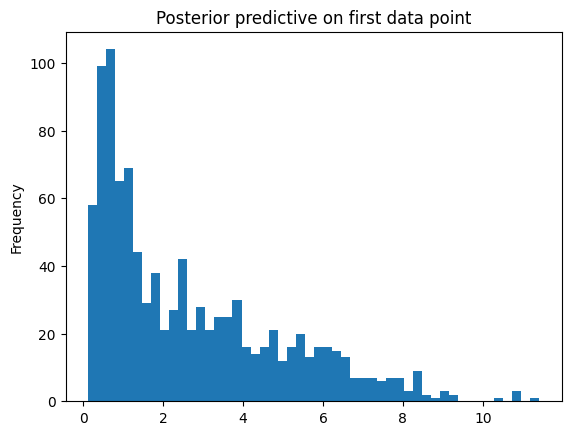

In [62]:
fig, ax = plt.subplots()
ax.hist(stan_data_simu_post.posterior_predictive.diabetes_pred.values.mean(axis=0)[:,0], bins=50)
ax.set(title="Posterior predictive on first data point", ylabel="Frequency")

<Axes: xlabel='diabetes / diabetes_pred'>

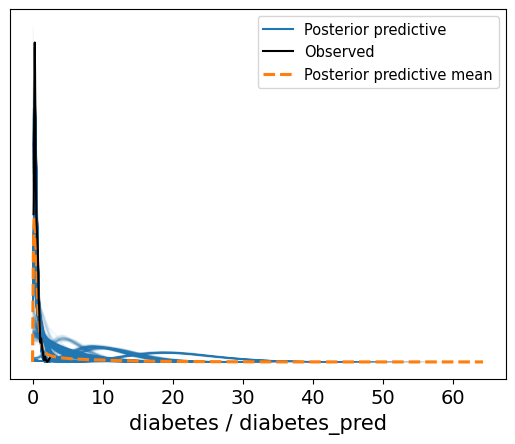

In [63]:
az.plot_ppc(stan_data_simu_post, kind="kde", data_pairs={"diabetes": "diabetes_pred"}, alpha=0.03, textsize=14)

## 3. Validate a fit. Diagnostics

The visualization shows that the simulated data sets (diabetes_rep) are different from observed log.

In [ ]:
## diagnostic test with treedepth 

def check_treedepth(summary, max_treedepth = 10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # sampler_params = fit.get_sampler_params(inc_warmup=False)
    sampler_params = summary.sample_stats['tree_depth'].values
    depths = [x for y in sampler_params for x in y]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet:
        print(('{} of {} iterations saturated the maximum tree depth of {}'
              + ' ({}%)').format(n, N, max_treedepth, 100 * n / N))
    if n > 0:
        if not quiet:
            print('  Run again with max_treedepth set to a larger value to avoid saturation')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
## diagnostic test with divergence

def check_div(summary, quiet=False):
    """Check transitions that ended with a divergence"""
    sampler_params = summary.sample_stats['diverging'].values
    divergent = [x for y in sampler_params for x in y]
    # n = sum(divergent)
    divergent = [True if element == "True" else False for element in divergent]
    n = divergent.count(True)
    N = len(divergent)
    if not quiet:
        print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))

    if n > 0:
        if not quiet:
            print('  Try running with larger adapt_delta to remove the divergences')
        else:
            return False
    else:
        if quiet:
            return True

In [ ]:
output = fit2.to_frame()

In [394]:
output

parameters       lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
draws                                                                         
0          -45.399201       0.982566    0.136220          8.0         332.0   
1          -46.133098       0.830933    0.256378          3.0          15.0   
2          -44.981790       0.797316    0.176783         10.0        1023.0   
3          -46.794435       0.999326    0.180619          4.0          23.0   
4          -44.870835       0.999896    0.136220         10.0        1023.0   
...               ...            ...         ...          ...           ...   
3995       -46.316339       1.000000    0.180619          3.0           7.0   
3996       -45.813490       0.997912    0.136220          2.0           7.0   
3997       -46.114026       0.951776    0.256378          2.0           7.0   
3998       -45.379258       0.916719    0.176783          4.0          15.0   
3999       -46.739118       0.993325    0.180619          5.0          31.0   

parameters  divergent__   energy__     alpha          beta     sigma  ...  \
draws                                                                 ...   
0                   1.0  50.177214  0.387283  1.062268e+06  5.592286  ...   
1                   0.0  47.075201  0.383949  3.181232e+08  5.331994  ...   
2                   0.0  49.278435  0.401317  2.474225e+07  5.244706  ...   
3                   0.0  49.122254  0.364465  7.997352e+07  5.668563  ...   
4                   0.0  45.783768  0.396799  6.196036e+05  5.334653  ...   
...                 ...        ...       ...           ...       ...  ...   
3995                0.0  47.306683  0.365782  3.719431e+08  5.888427  ...   
3996                0.0  46.288417  0.418556  2.797461e+07  5.122871  ...   
3997                0.0  47.323385  0.383099  1.400683e+09  5.347539  ...   
3998                0.0  49.513809  0.412714  1.118615e+08  5.161481  ...   
3999                0.0  46.966469  0.359102  3.718678e+08  5.862878  ...   

parameters  diabetes_pred.759  diabetes_pred.760  diabetes_pred.761  \
draws                                                                 
0                    0.390911           0.514590           0.444172   
1                    0.188899           0.126332           0.375260   
2                    0.331712           0.047142           1.419871   
3                    0.549941           0.422825           0.512685   
4                    0.443067           0.660527           0.360199   
...                       ...                ...                ...   
3995                 0.608937           0.041528           0.307735   
3996                 0.065346           0.270619           1.125526   
3997                 0.284736           0.403669           0.887529   
3998                 0.454249           0.575356           0.149126   
3999                 0.665271           0.460335           0.461773   

parameters  diabetes_pred.762  diabetes_pred.763  diabetes_pred.764  \
draws                                                                 
0                    0.658557           0.452991           0.157936   
1                    0.224233           0.409634           0.202506   
2                    0.510174           0.455131           0.375943   
3                    0.855164           0.301422           1.103874   
4                    0.163151           0.656618           0.284381   
...                       ...                ...                ...   
3995                 0.135491           0.070987           0.150555   
3996                 0.186036           0.447382           1.111968   
3997                 0.370546           0.263015           0.424008   
3998                 1.363892           0.875676           0.413616   
3999                 2.124312           0.488762           0.360811   

parameters  diabetes_pred.765  diabetes_pred.766  diabetes_pred.767  \
draws                                              

In [395]:
summary = az.summary(fit2) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [396]:
summary
## mcse_mean : Markov Chain Standard Error statistic
## ess_bulk : effective sample size  


mean            sd      hdi_3%       hdi_97%  \
alpha               3.950000e-01  1.900000e-02       0.361  4.320000e-01   
beta                4.703225e+08  7.557175e+08  380229.438  2.274096e+09   
sigma               5.374000e+00  2.870000e-01       4.853  5.914000e+00   
alpha_inv           2.537000e+00  1.210000e-01       2.310  2.763000e+00   
beta_inv            0.000000e+00  0.000000e+00       0.000  0.000000e+00   
...                          ...           ...         ...           ...   
diabetes_pred[763]  4.690000e-01  2.920000e-01       0.035  1.010000e+00   
diabetes_pred[764]  4.710000e-01  2.970000e-01       0.036  9.970000e-01   
diabetes_pred[765]  4.790000e-01  3.050000e-01       0.023  1.013000e+00   
diabetes_pred[766]  4.700000e-01  2.980000e-01       0.034  1.001000e+00   
diabetes_pred[767]  4.730000e-01  2.990000e-01       0.041  1.001000e+00   

                       mcse_mean       mcse_sd  ess_bulk  ess_tail  r_hat  
alpha               0.000000e+00  0.000000e+00    2128.0    1846.0   1.01  
beta                3.490839e+08  2.640732e+08       5.0      14.0   2.57  
sigma               6.000000e-03  5.000000e-03    2022.0    1658.0   1.00  
alpha_inv           3.000000e-03  2.000000e-03    2128.0    1846.0   1.00  
beta_inv            0.000000e+00  0.000000e+00       5.0      14.0   2.57  
...                          ...           ...       ...       ...    ...  
diabetes_pred[763]  5.000000e-03  3.000000e-03    3767.0    3623.0   1.00  
diabetes_pred[764]  5.000000e-03  3.000000e-03    3950.0    3858.0   1.00  
diabetes_pred[765]  5.000000e-03  3.000000e-03    4058.0    3732.0   1.00  
diabetes_pred[766]  5.000000e-03  3.000000e-03    4181.0    3928.0   1.00  
diabetes_pred[767]  5.000000e-03  4.000000e-03    4115.0    3961.0   1.00  

[773 rows x 9 columns]

In [397]:
check_treedepth(stan_data_simu_post)

1674 of 4000 iterations saturated the maximum tree depth of 10 (41.85%)
  Run again with max_treedepth set to a larger value to avoid saturation


In [398]:
check_div(stan_data_simu_post)

0 of 4000 iterations ended with a divergence (0.0%)


In [399]:
filtered_df = summary[summary['r_hat'] > 1.0]

In [400]:
filtered_df

mean            sd      hdi_3%       hdi_97%     mcse_mean  \
alpha     3.950000e-01  1.900000e-02       0.361  4.320000e-01  0.000000e+00   
beta      4.703225e+08  7.557175e+08  380229.438  2.274096e+09  3.490839e+08   
beta_inv  0.000000e+00  0.000000e+00       0.000  0.000000e+00  0.000000e+00   

               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha     0.000000e+00    2128.0    1846.0   1.01  
beta      2.640732e+08       5.0      14.0   2.57  
beta_inv  0.000000e+00       5.0      14.0   2.57

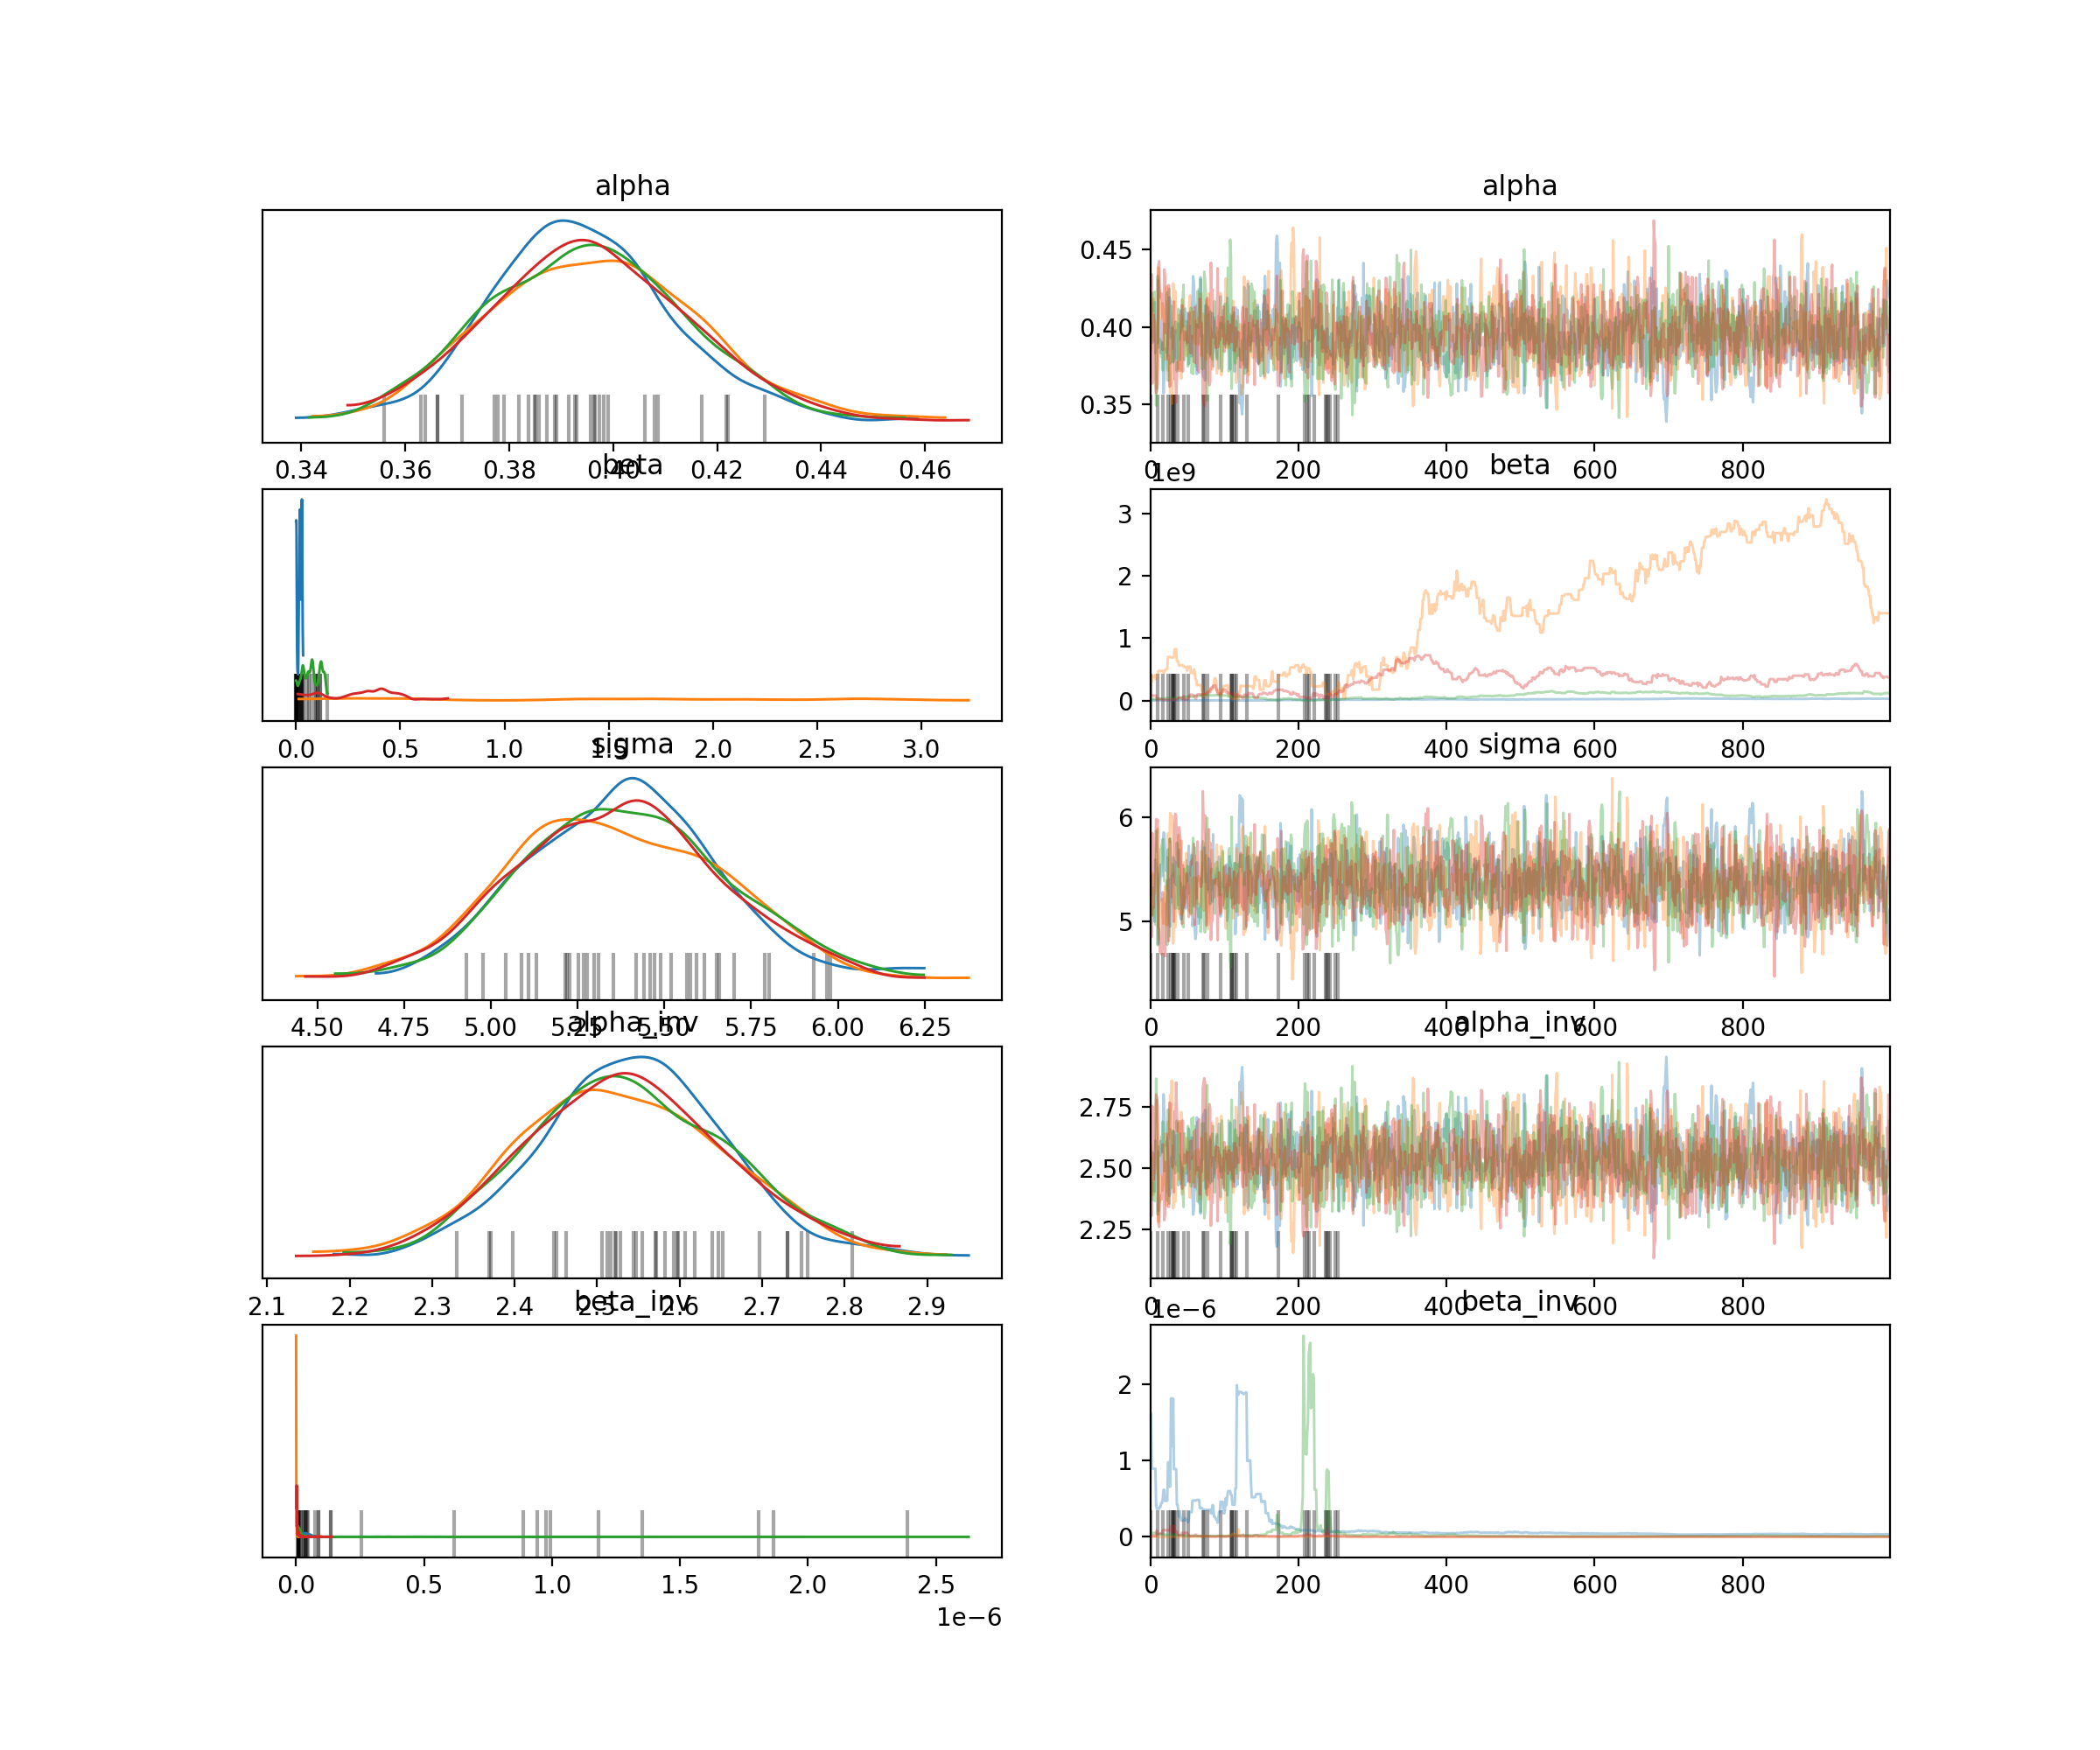

In [401]:
az.plot_trace(stan_data_simu_post, compact=False);

In [381]:
az.plot_posterior(fit)

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (771) in plot_posterior, generating only 40 plots


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'diabetes_pred\n0'}>],
       [<Axes: title={'center': 'diabetes_pred\n1'}>,
        <Axes: title={'center': 'diabetes_pred\n2'}>,
        <Axes: title={'center': 'diabetes_pred\n3'}>,
        <Axes: title={'center': 'diabetes_pred\n4'}>],
       [<Axes: title={'center': 'diabetes_pred\n5'}>,
        <Axes: title={'center': 'diabetes_pred\n6'}>,
        <Axes: title={'center': 'diabetes_pred\n7'}>,
        <Axes: title={'center': 'diabetes_pred\n8'}>],
       [<Axes: title={'center': 'diabetes_pred\n9'}>,
        <Axes: title={'center': 'diabetes_pred\n10'}>,
        <Axes: title={'center': 'diabetes_pred\n11'}>,
        <Axes: title={'center': 'diabetes_pred\n12'}>],
       [<Axes: title={'center': 'diabetes_pred\n13'}>,
        <Axes: title={'center': 'diabetes_pred\n14'}>,
        <Axes: title={'center': 'diabetes_pred\n15'}>

## 0. delete cache of model

In [26]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [27]:
httpstan.cache.list_model_names()

['models/ipnkzw2z',
 'models/jtyjyub2',
 'models/6l34yh24',
 'models/64wa4gsp',
 'models/4gvnnasb',
 'models/rkp75vbj',
 'models/h2b2yeyb',
 'models/pysrfznp',
 'models/o3ec5avh',
 'models/cx66kwge']

In [33]:
httpstan.cache.delete_model_directory('models/h2b2yeyb') ## add the model pointer you want to remove

## 0. Saving model (not done)

In [24]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [25]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')


In [188]:
import pickle

In [26]:
# with open("model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# fit_new = data_dict['fit']
# # fit = data_list[1]

In [ ]:
# with open("model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : stan_model, 'fit' : fit}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)